# Assignment 8: DT

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(you can write your own for loops refer sample solution)</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points`</li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
   <li><b>Task 2: </b>For this task consider set-1 features. Select all the features which are having non-zero feature importance.You can get the feature importance using  'feature_importances_` 
   (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3<br>
  Note: when you want to find the feature importance make sure you don't use max_depth parameter keep it None.
  </li>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>1. Decision Tree </h1>

## 1.1 Loading Data

In [2]:
import pandas
data = pandas.read_csv(r'C:\Users\hoj5kor\Desktop\GIT\preprocessed_data.csv')

In [3]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [4]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.model_selection import train_test_split
X = data.drop('project_is_approved',axis=1)
y = data['project_is_approved']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=42,stratify=y)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size=0.15,random_state=42,stratify=y_train)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_train.shape)
print(X_cv.shape,y_cv.shape)

(78931, 8) (78931,)
(16388, 8) (78931,)
(13929, 8) (13929,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [5]:
import pickle
with open(r'C:\Users\hoj5kor\Desktop\GIT\glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [6]:
from tqdm import tqdm
def tfidf_w2v(vectorizer, data):
    dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
    tfidf_words = set(vectorizer.get_feature_names())
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    return np.array(tfidf_w2v_vectors)

In [7]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

feature_names = []

TfidfVec = TfidfVectorizer(ngram_range=(1,4),min_df=10,max_features=5000)
TfidfVec.fit(X_train['essay'].values)

X_train_TfidfVec = TfidfVec.transform(X_train['essay'].values)
X_train_TfidfW2V = tfidf_w2v(TfidfVec, X_train['essay'].values)
X_test_TfidfVec = TfidfVec.transform(X_test['essay'].values)
X_test_TfidfW2V = tfidf_w2v(TfidfVec, X_test['essay'].values)
X_cv_TfidfVec = TfidfVec.transform(X_cv['essay'].values)
X_cv_TfidfW2V = tfidf_w2v(TfidfVec, X_cv['essay'].values)

print('After Vectorization')
print('='*50)
print(X_train_TfidfVec.shape, y_train.shape)
print(X_test_TfidfVec.shape, y_test.shape)
print(X_cv_TfidfVec.shape, y_cv.shape)
print('='*50)
print(X_train_TfidfW2V.shape, y_train.shape)
print(X_test_TfidfW2V.shape, y_test.shape)
print(X_cv_TfidfW2V.shape, y_cv.shape)
print('='*50)
print(TfidfVec.get_feature_names()[:10])
feature_names.extend(TfidfVec.get_feature_names())

100%|███████████████████████████████████████████████████████████████████████████| 13929/13929 [00:32<00:00, 422.59it/s]


After Vectorization
(78931, 5000) (78931,)
(16388, 5000) (16388,)
(13929, 5000) (13929,)
(78931, 300) (78931,)
(16388, 300) (16388,)
(13929, 300) (13929,)
['000', '10', '100', '100 free', '100 percent', '100 students', '100 students receive', '100 students receive free', '11', '12']


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [8]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
# encoding categorical features using tfidf vectorizer
    
# encoding school_state
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['school_state'].values)

X_train_state_tfidf = vectorizer.transform(X_train['school_state'].values)
X_test_state_tfidf = vectorizer.transform(X_test['school_state'].values)
X_cv_state_tfidf = vectorizer.transform(X_cv['school_state'].values)


print(vectorizer.get_feature_names()[:5])
feature_names.extend(vectorizer.get_feature_names())

# encoding teacher_prefix
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)

X_train_teacher_prefix_tfidf = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_prefix_tfidf = vectorizer.transform(X_test['teacher_prefix'].values)
X_cv_teacher_prefix_tfidf = vectorizer.transform(X_cv['teacher_prefix'].values)

print(vectorizer.get_feature_names()[:5])
feature_names.extend(vectorizer.get_feature_names())

# encoding project_grade_category
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)

X_train_project_grade_category_tfidf = vectorizer.transform(X_train['project_grade_category'].values)
X_test_project_grade_category_tfidf = vectorizer.transform(X_test['project_grade_category'].values)
X_cv_project_grade_category_tfidf = vectorizer.transform(X_cv['project_grade_category'].values)

print(vectorizer.get_feature_names()[:5])
feature_names.extend(vectorizer.get_feature_names())

# encoding clean_categories
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['clean_categories'].values)

X_train_clean_categories_tfidf = vectorizer.transform(X_train['clean_categories'].values)
X_test_clean_categories_tfidf = vectorizer.transform(X_test['clean_categories'].values)
X_cv_clean_categories_tfidf = vectorizer.transform(X_cv['clean_categories'].values)

print(vectorizer.get_feature_names()[:5])
feature_names.extend(vectorizer.get_feature_names())


# encoding clean_subcategories
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)

X_train_clean_subcategories_tfidf = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_clean_subcategories_tfidf = vectorizer.transform(X_test['clean_subcategories'].values)
X_cv_clean_subcategories_tfidf = vectorizer.transform(X_cv['clean_subcategories'].values)

print(vectorizer.get_feature_names()[:5])
feature_names.extend(vectorizer.get_feature_names())

['ak', 'al', 'ar', 'az', 'ca']
['dr', 'mr', 'mrs', 'ms', 'teacher']
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language']
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep']


In [9]:
# encoding numerical features
# encoding price

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1)).reshape(-1,1)
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1)).reshape(-1,1)
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1)).reshape(-1,1)

print(X_cv_price_norm[:10])

# encoding teacher_number_of_previously_posted_projects

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)
X_cv_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)

print('='*25)
print(X_train_teacher_number_of_previously_posted_projects_norm[:10])

[[0.00279308]
 [0.00579594]
 [0.00704402]
 [0.01440459]
 [0.00138981]
 [0.00613287]
 [0.00139355]
 [0.00130866]
 [0.00570264]
 [0.0009347 ]]
[[0.        ]
 [0.00155586]
 [0.00682187]
 [0.00059841]
 [0.00155586]
 [0.02752684]
 [0.        ]
 [0.00071809]
 [0.00251332]
 [0.00167555]]


<h2>1.5 Appling  Decision Tree on different kind of featurization as mentioned in the instructions</h2>

<br>Apply  Decision Tree on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [10]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
# concatenating all features
from scipy.sparse import hstack

X_tr_tfidf = hstack((X_train_TfidfVec,X_train_state_tfidf,X_train_teacher_prefix_tfidf,X_train_project_grade_category_tfidf,X_train_clean_categories_tfidf,X_train_clean_subcategories_tfidf,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_cv_tfidf = hstack((X_cv_TfidfVec,X_cv_state_tfidf,X_cv_teacher_prefix_tfidf,X_cv_project_grade_category_tfidf,X_cv_clean_categories_tfidf,X_cv_clean_subcategories_tfidf,X_cv_price_norm,X_cv_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_te_tfidf = hstack((X_test_TfidfVec,X_test_state_tfidf,X_test_teacher_prefix_tfidf,X_test_project_grade_category_tfidf,X_test_clean_categories_tfidf,X_test_clean_subcategories_tfidf,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm)).tocsr()
print(X_train_state_tfidf.shape)
X_tr_tfidfw2v = hstack((X_train_TfidfW2V,X_train_state_tfidf,X_train_teacher_prefix_tfidf,X_train_project_grade_category_tfidf,X_train_clean_categories_tfidf,X_train_clean_subcategories_tfidf,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_cv_tfidfw2v = hstack((X_cv_TfidfW2V,X_cv_state_tfidf,X_cv_teacher_prefix_tfidf,X_cv_project_grade_category_tfidf,X_cv_clean_categories_tfidf,X_cv_clean_subcategories_tfidf,X_cv_price_norm,X_cv_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_te_tfidfw2v = hstack((X_test_TfidfW2V,X_test_state_tfidf,X_test_teacher_prefix_tfidf,X_test_project_grade_category_tfidf,X_test_clean_categories_tfidf,X_test_clean_subcategories_tfidf,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm)).tocsr()

print("Final Data matrix")
print('='*50)
print(X_tr_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_te_tfidf.shape, y_test.shape)
print('='*50)
print(X_tr_tfidfw2v.shape, y_train.shape)
print(X_cv_tfidfw2v.shape, y_cv.shape)
print(X_te_tfidfw2v.shape, y_test.shape)

(78931, 51)
Final Data matrix
(78931, 5101) (78931,)
(13929, 5101) (13929,)
(16388, 5101) (16388,)
(78931, 401) (78931,)
(13929, 401) (13929,)
(16388, 401) (16388,)


In [11]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#parameters = {'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
depth=[1, 5, 10, 50]
min_samples_split=[5, 10, 100, 500]
train_auc = [[0 for samples in min_samples_split]for max_depth in depth]
cv_auc = [[0 for samples in min_samples_split]for max_depth in depth]
i=0
for max_depth in depth:
    j = 0
    for samples in min_samples_split:
        clf_tfidf = DecisionTreeClassifier(max_depth = max_depth,min_samples_split=samples)
        clf_tfidf.fit(X_tr_tfidf, y_train)

        y_train_pred = batch_predict(clf_tfidf, X_tr_tfidf)    
        y_cv_pred = batch_predict(clf_tfidf, X_cv_tfidf)
        
        train_auc[i][j] = roc_auc_score(y_train,y_train_pred)
        cv_auc[i][j] = roc_auc_score(y_cv, y_cv_pred)
        j += 1
    i += 1
    
sns.heatmap(train_auc,annot=True,xticklabels=min_samples_split,yticklabels=depth)
plt.title('Heatmap TFIDF vectorization (AUC vs Hyperparameters) on Training data')
plt.ylabel('Max Depth')
plt.xlabel('Min Samples Split')
plt.show()

<Figure size 640x480 with 2 Axes>

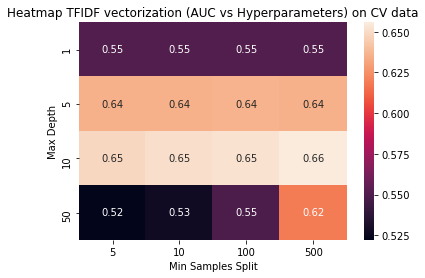

In [13]:
sns.heatmap(cv_auc,annot=True,xticklabels=min_samples_split,yticklabels=depth)
plt.title('Heatmap TFIDF vectorization (AUC vs Hyperparameters) on CV data')
plt.ylabel('Max Depth')
plt.xlabel('Min Samples Split')
plt.show()

From the above plots, we can see that Max_Depth=10 and Min_Samples_Split=500 leads to the best performance.

Confusion Matrix
[[  104 13714]
 [  193  2377]]
Accuracy Score:  0.8431779350744447


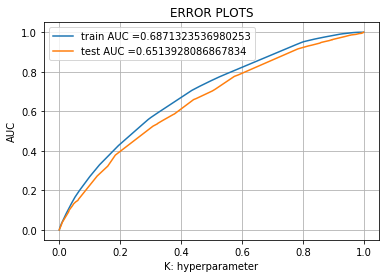

In [14]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

clf = DecisionTreeClassifier(max_depth = 10,min_samples_split=500)
clf.fit(X_tr_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr_tfidf)    
y_test_pred = batch_predict(clf, X_te_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

y_test_class = list(map(lambda x:1 if x>=0.5 else 0, y_test_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_class).ravel()
print('Confusion Matrix')
print('================')
print(np.array([[tn, tp],[fn, fp]]))
print('Accuracy Score: ',accuracy_score(y_test, y_test_class))

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [90]:
X_test.values[1]
y_test.values[1]

1

In [102]:
#get all false positives
#(movies.duration >= 200) & (movies.genre == 'Drama')
fp = []
for i in range(len(y_test)):
    if y_test.values[i]==0 and y_test_class[i]==1:
        fp.append(X_test.values[i][-2])

print(len(fp))

2377


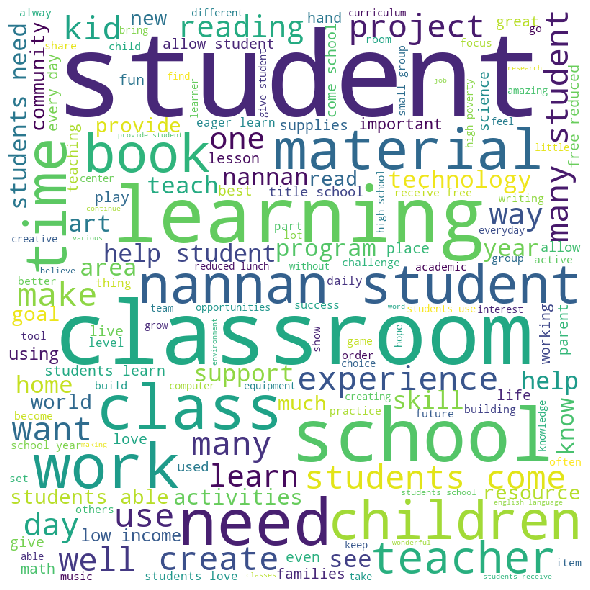

In [101]:
from wordcloud import WordCloud, STOPWORDS 

comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in fp: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split()   
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()      
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

TypeError: cannot perform reduce with flexible type

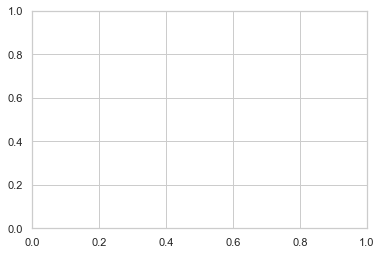

In [104]:
#Plot the box plot with the `price` of these `false positive data points`
import seaborn as sns
sns.set(style="whitegrid")
sns.boxplot(fp)
plt.show()

In [ ]:
#for tfidf-w2v
train_auc = [[0 for samples in min_samples_split]for max_depth in depth]
cv_auc = [[0 for samples in min_samples_split]for max_depth in depth]
i=0
for max_depth in depth:
    j= 0
    for samples in min_samples_split:
        clf_tfidfw2v = DecisionTreeClassifier(max_depth = max_depth,min_samples_split=samples)
        clf_tfidfw2v.fit(X_tr_tfidfw2v, y_train)

        y_train_pred = batch_predict(clf_tfidfw2v, X_tr_tfidfw2v)    
        y_cv_pred = batch_predict(clf_tfidfw2v, X_cv_tfidfw2v)
        
        train_auc[i][j] = roc_auc_score(y_train,y_train_pred)
        cv_auc[i][j] = roc_auc_score(y_cv, y_cv_pred)
        j += 1
    i += 1
    
sns.heatmap(train_auc,annot=True,xticklabels=min_samples_split,yticklabels=depth)
plt.title('Heatmap TFIDF-W2V vectorization (AUC vs Hyperparameters) on Training data')
plt.ylabel('Max Depth')
plt.xlabel('Min Samples Split')
plt.show()

In [ ]:
sns.heatmap(cv_auc,annot=True,xticklabels=min_samples_split,yticklabels=depth)
plt.title('Heatmap TFIDF-W2V vectorization (AUC vs Hyperparameters) on CV data')
plt.ylabel('Max Depth')
plt.xlabel('Min Samples Split')
plt.show()

From the above plots, we can see that Max_Depth=5 and Min_Samples_Split=500 leads to the best performance.

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

clf = DecisionTreeClassifier(max_depth = 5,min_samples_split=500)
clf.fit(X_tr_tfidfw2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr_tfidfw2v)    
y_test_pred = batch_predict(clf, X_te_tfidfw2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

y_test_class = list(map(lambda x:1 if x>=0.5 else 0, y_test_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_class).ravel()
print('Confusion Matrix')
print('================')
print(np.array([[tn, tp],[fn, fp]]))
print('Accuracy Score: ',accuracy_score(y_test, y_test_class))

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
'''train_auc = []
cv_auc = []
for max_depth in tqdm(depth):
    clf_tfidfw2v = DecisionTreeClassifier(max_depth = max_depth)
    clf_tfidfw2v.fit(X_tr_tfidfw2v, y_train)

    y_train_pred = batch_predict(clf_tfidfw2v, X_tr_tfidfw2v)    
    y_cv_pred = batch_predict(cclf_tfidfw2vlf, X_cv_tfidfw2v)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(depth, train_auc, label='Train AUC')
plt.plot(depth, cv_auc, label='CV AUC')

plt.scatter(depth, train_auc, label='Train AUC points')
plt.scatter(depth, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Max_depth: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC Scores vs Max_depth")
plt.grid()
plt.show()'''

<h2>1.6 Getting top features using `feature_importances_`</h2>

In [ ]:
'''# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
#Top 20 features for Tfidf
min_indices = np.argsort(clf_tfidf.feature_importances_)
max_indices = min_indices[::-1][:20]
np.take(feature_names,max_indices)[:20] '''

In [ ]:
'''#Top 20 features for Tfidf-w2v
min_indices = np.argsort(clf_tfidfw2v.feature_importances_)
max_indices = min_indices[::-1][:20]
np.take(feature_names,max_indices)[:20] '''

<h1>2. Summary</h1>